In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle

import torch
from wotan import flatten
from scipy.ndimage import gaussian_filter1d

import visualize as vis

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [52]:
def load_stats(path):
    with open(path, "rb") as f:
        dic = pickle.load(f)
    return dic

def plot_results(dic, m, rng=(), split="valid", lbl="", linestyle="-", fill=True, return_c=True, c=None, s=2, a=0.3):
    x = np.arange(len(dic["mean"]["metrics"]["train"][()]["acc"]))
    p = plt.plot(x, dic["mean"]["metrics"][split][rng][m], linestyle=linestyle, label=lbl, color=c, linewidth=s)
    if fill:
        plt.fill_between(x, dic["mean"]["metrics"][split][rng][m]-dic["std"]["metrics"][split][rng][m],
                        dic["mean"]["metrics"][split][rng][m]+dic["std"]["metrics"][split][rng][m], alpha=a, color=p[0].get_color())
    return p[0].get_color() if return_c else None

def make_plot(fnames, metric, split, table=False, ylbl="", ylbl2="", title="", 
              pr_curve=False, legend_next=False, figsize=(10,3), show=False, incl_totap=True,
             round_lst=None, prepend="\n", append_lst=None, bbox_help=(1,1)):
    if round_lst is None:
        round_lst = [[2,2] for i in range(len(fnames))]
    if append_lst is None:
        append_lst = [["",""] for i in range(len(fnames))]
    means_list, stds_list = [], [] 
    tot_means, tot_stds = [], []
    for fnm, mname in fnames.items():
        stats = load_stats("models_all/"+fnm+"/stats_avg.pkl")
        mean_dic, std_dic = stats["mean"]["metrics"][split], stats["std"]["metrics"][split]
        rnges, means, stds = [], [], []
        tot_means.append(mean_dic[()][metric])
        tot_stds.append(std_dic[()][metric])
        for rng in list(mean_dic.keys())[1:]:
            rnges.append(np.mean(rng) if rng[-1]<5 else 5)
            means.append(mean_dic[rng][metric])
            stds.append(std_dic[rng][metric])
        means_list.append(np.array(means)), stds_list.append(np.array(stds))

    plt.figure(figsize=figsize)
    for sub in range(2):
        plt.subplot(1,2+pr_curve,sub+1)
        ttl = title if sub==0 else "Relative differences"
        plt.title(ttl, fontsize=14)

        mean_means = 0 if sub==0 else np.array(means_list).mean(0)
        for i, (fname, mname) in enumerate(fnames.items()):
            rounds = round_lst[i]
            app = append_lst[i]
            mean, std = means_list[i], stds_list[i]
            tot_mean, tot_std = tot_means[i], tot_stds[i]
            
            lbl = mname if sub==1 else None
            if incl_totap and lbl is not None:
                lbl += f"{prepend}({round(tot_mean,rounds[0])}{app[0]} $\pm$ {round(tot_std,rounds[1])}{app[1]})"
            
            p = plt.plot(rnges, mean-mean_means, label=lbl)
            plt.scatter(rnges, mean-mean_means, c=p[0].get_color(), zorder=20)
            plt.fill_between(rnges, mean-std-mean_means, mean+std-mean_means, alpha=0.3)
           
        plt.xticks([0,1,2,2,3,4,5], [0,1,2,2,3,4,5], fontsize=13),plt.yticks(fontsize=13)
        
        if sub==1:
            plt.axhline(0, linestyle="--", color="gray")
            ylbl = ylbl if  ylbl2=="" else ylbl2
        else:
            plt.ylim(0,1)
        ylbl = ylbl if sub==0 else ylbl + " from mean"
        plt.ylabel(ylbl, fontsize=14)
        plt.xlabel("Transit depth over \nnoise level ($\delta$/$\sigma$)", fontsize=14)
        if legend_next and not pr_curve:
            plt.legend(fontsize=12, bbox_to_anchor=(1,1)) if sub==1 else None
        elif not legend_next:
            plt.legend(fontsize=12) if sub==0 else None
    if pr_curve:
        plt.subplot(1,2+pr_curve,3)
        thresholds = np.linspace(0,1,20)
        for i, (fname, mname) in enumerate(fnames.items()):
            rounds=round_lst[i]
            app = append_lst[i]
            stats = load_stats("models_all/"+fname+"/stats_avg.pkl")
            tot_mean, tot_std = tot_means[i], tot_stds[i]
            for j, m in enumerate(["thresh_prec", "thresh_rec"]):
                mean = stats["mean"]["metrics"][split][()][m]
                std = stats["std"]["metrics"][split][()][m]
                
                lbl = mname if j==0 else None
                if incl_totap and lbl is not None:
                    lbl += f"{prepend}({round(tot_mean,rounds[0])}{app[0]} $\pm$ {round(tot_std,rounds[1])}{app[1]})"
                p = plt.plot(thresholds, mean, linestyle="-" if j==0 else "--", 
                             color=None if j==0 else p[0].get_color(), linewidth=2, label=lbl)
                plt.fill_between(thresholds, mean-std, mean+std, alpha=0.2, color=p[0].get_color())
        plt.title("Precision-recall tradeoff",fontsize=14) 
        plt.xticks([0.,.2,.4,.6,.8,1.],[0.,.2,.4,.6,.8,1.], fontsize=13), plt.yticks(fontsize=13)
        plt.xlim(-.05,1.05), plt.ylim(0,1.1)
        
        plt.xlabel("Classification threshold", fontsize=14), plt.ylabel("Metric value", fontsize=14)
        if legend_next and pr_curve:
            plt.legend(fontsize=12, bbox_to_anchor=bbox_help)
        
        plt.twinx()
        plt.yticks([])
        plt.plot([], linestyle="-", color="gray", label="precision")    
        plt.plot([], linestyle="--", color="gray", label="recall")
        plt.legend(fontsize=12, loc="upper right", framealpha=0.9)#, bbox_to_anchor=(1,1)
        
    plt.tight_layout()
    if show:
        plt.show()

In [43]:
def get_aps(fnames, metric, split):
    for fnm, mname in fnames.items():
        stats = load_stats("models_all/"+fnm+"/stats_avg.pkl")
        mean_dic, std_dic = stats["mean"]["metrics"][split], stats["std"]["metrics"][split]
        mean,std = mean_dic[()][metric],  std_dic[()][metric]
        print("{:20}  :  {:<6.3}   +/-  {:<7.2}  ({:<6.3}, {:<6.3})".format(mname, mean, std, mean-std,mean+std))

In [44]:
mnames = ["mlp", "cnn", "rnn_naive_notbi", "gru1", "bigru1", "bigru2", "bilstm1"][::-1]
labels = ["MLP", "CNN", "GRU-1 (Naive)", "GRU-1", "bi-GRU-1", "bi-GRU-2", "bi-LSTM-1"][::-1]

results = {500:{},1500:{}}
for mname in mnames:
    for n in [500,1500]:
        path = "results/training/"
        fname = mname+"_sim.pkl" if n==1500 else mname+"_sim500.pkl"
        with open(path + fname, "rb") as f:
            results[n][mname] = pickle.load(f)

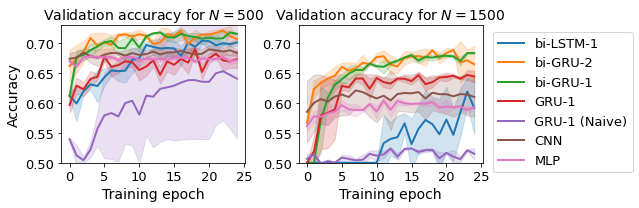

In [20]:
sparse=False
if sparse:
    mnames = ["mlp", "cnn",  "gru1", "bigru1",  "bilstm1"][::-1]
    labels = ["MLP", "CNN",  "GRU-1", "bi-GRU-1", "bi-LSTM-1"][::-1]
else:
    mnames = ["mlp", "cnn", "rnn_naive_notbi", "gru1", "bigru1", "bigru2", "bilstm1"][::-1]
    labels = ["MLP", "CNN", "GRU-1 (Naive)", "GRU-1", "bi-GRU-1", "bi-GRU-2", "bi-LSTM-1"][::-1]
colors = [plt.plot([])[0].get_color() for m in mnames]
plt.close()
plt.figure(figsize=(9,3))
for n in [500, 1500]:
  plt.subplot(1,2,(n==1500)+1)
  for i, (mname, lbl) in enumerate(zip(mnames, labels)):
    try:
      plot_results(results[n][mname],
                "acc_seg", split="valid", lbl=lbl, fill=1, s=2, a=.2, c=colors[i])
    except:
        print("error")
        pass
  plt.legend(fontsize=13, bbox_to_anchor=(1.02, 1)) if n == 1500 else None
  plt.ylim(.5, 0.73) #if n == 500 else plt.ylim(.5, 0.7)
  plt.title(f"Validation accuracy for $N = {n}$", fontsize=14)
  plt.xticks(fontsize=13)
  plt.yticks(fontsize=13)

  plt.xlabel("Training epoch", fontsize=14)
  plt.ylabel("Accuracy", fontsize=14) if n == 500 else None
plt.tight_layout()
plt.savefig("figures/identification"+sparse*"_sparse"+".pdf")
plt.show()

In [21]:
split="test"
print(" "*15 + "N = 500" + " "*15 + "N = 1500")
for i, (mname, lbl) in enumerate(zip(mnames[::-1], labels[::-1])):
    acc500 = results[500][mname]["mean"]["metrics"][split][()]["acc_seg"]
    acc500std = results[500][mname]["std"]["metrics"][split][()]["acc_seg"]
    
    acc1500 = results[1500][mname]["mean"]["metrics"][split][()]["acc_seg"]
    acc1500std = results[1500][mname]["std"]["metrics"][split][()]["acc_seg"]
    
    _acc1500 = results[1500][mname]["mean"]["metrics"][split][()]["acc"]
    _acc1500std = results[1500][mname]["std"]["metrics"][split][()]["acc"]
    
    print("{:<14}, ".format(lbl) +\
          "{:<5.4} $\pm$ {:<12.3},".format(acc500, acc500std) +\
          "{:<5.4} $\pm$ {:<12.3},".format(acc1500, acc1500std)+\
          "{:<5.4} $\pm$ {:<12.3}".format(_acc1500, _acc1500std))

               N = 500               N = 1500
MLP           , 0.6846 $\pm$ 0.000748    ,0.5967 $\pm$ 0.0119      ,0.5967 $\pm$ 0.0119      
CNN           , 0.6928 $\pm$ 0.00843     ,0.6135 $\pm$ 0.0326      ,0.6135 $\pm$ 0.0326      
GRU-1 (Naive) , 0.6398 $\pm$ 0.0993      ,0.5071 $\pm$ 0.0055      ,0.5071 $\pm$ 0.0055      
GRU-1         , 0.6764 $\pm$ 0.0174      ,0.6395 $\pm$ 0.0102      ,0.9354 $\pm$ 0.00145     
bi-GRU-1      , 0.7193 $\pm$ 0.00293     ,0.6808 $\pm$ 0.00408     ,0.9399 $\pm$ 0.00036     
bi-GRU-2      , 0.7119 $\pm$ 0.0045      ,0.6593 $\pm$ 0.0304      ,0.9381 $\pm$ 0.003       
bi-LSTM-1     , 0.7075 $\pm$ 0.00547     ,0.5895 $\pm$ 0.0413      ,0.931 $\pm$ 0.00322     


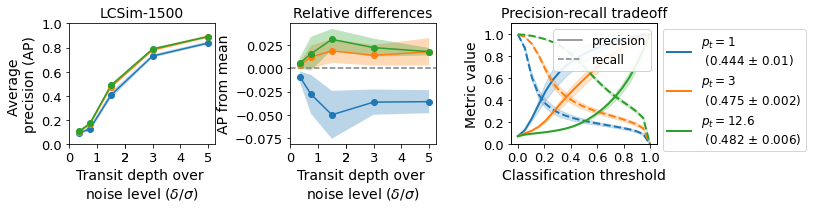

In [61]:
fnames = {"lcsim1500_bigru1_m1"       :"$p_t = 1$",
          'lcsim1500_bigru1_m1_w3'    :"$p_t = 3$",
          'lcsim1500_bigru1_m1_w12.6' :"$p_t = 12.6$"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="Average \nprecision (AP)", 
          ylbl2="AP", title="LCSim-1500", pr_curve=True, legend_next=1, figsize=(11.4,3),
         round_lst=[[3,3] for i in range(3)], prepend="\n ")
plt.savefig("figures/lcsim1500_AP_weighting-p.pdf")
plt.show()
# metric, split = "aucroc", "test"
# make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

In [38]:
get_aps(fnames, metric, split)

$p_t = 1$             :  0.444    +/-  0.0097   (0.435 , 0.454 )
$p_t = 3$             :  0.475    +/-  0.002    (0.473 , 0.477 )
$p_t = 12.6$          :  0.482    +/-  0.006    (0.476 , 0.488 )


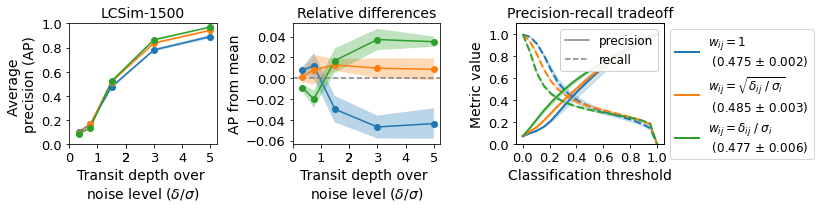

In [62]:
fnames = {'lcsim1500_bigru1_m1_w3'    :"$w_{ij} = 1$",
          'lcsim1500_bigru1_m1_w3sqrt' :"$w_{ij} = \sqrt{\delta_{ij} \;/ \; \sigma_i}$",
          'lcsim1500_bigru1_m1_w3snr':"$w_{ij} = \delta_{ij} \; / \; \sigma_i$"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="Average \nprecision (AP)", 
          ylbl2="AP", title="LCSim-1500", pr_curve=True, legend_next=True, figsize=(11.5,3),
         round_lst=[[3,3] for i in range(3)], prepend="\n ")
plt.savefig("figures/lcsim1500_AP_weighting-w.pdf")
plt.show()
# metric, split = "aucroc", "test"
# make_plot(fnames, metric, split, ylbl="AUCROC", title="LCSim-1500 test")

In [28]:
get_aps(fnames, metric, split)

$p_t = 1$, $w_{ij} = 1$  :  0.543    +/-  0.0092   (0.534 , 0.552 )
$p_t = 3$, $w_{ij} = 1$  :  0.569    +/-  0.00061  (0.569 , 0.57  )
$p_t = 3$, $w_{ij} = \sqrt{\delta_{ij} \;/ \; \sigma_i}$  :  0.555    +/-  0.016    (0.539 , 0.57  )
$p_t = 3$, $w_{ij} = \delta_{ij} \; / \; \sigma_i$  :  0.546    +/-  0.0019   (0.544 , 0.547 )


In [35]:
print("\033[1mpoop \033[0m poop")

poop  poop


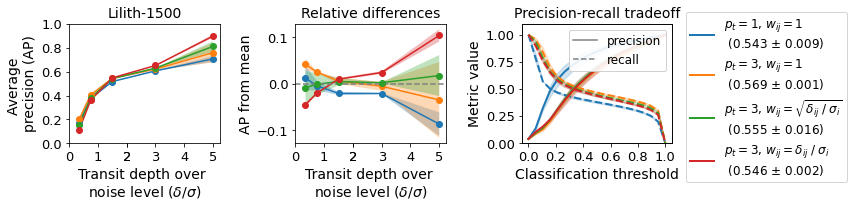

In [63]:
fnames = {'lilith1500basic_bigru1_m1_n2'    :"$p_t = 1$, $w_{ij} = 1$",
          'lilith1500basic_bigru1_m1_w3'    :"$p_t = 3$, $w_{ij} = 1$",
          'lilith1500basic_bigru1_m1_w3sqrt':"$p_t = 3$, $w_{ij} = \sqrt{\delta_{ij} \;/ \; \sigma_i}$",
          'lilith1500basic_bigru1_m1_w3snr':"$p_t = 3$, $w_{ij} = \delta_{ij} \; / \; \sigma_i$"}

metric, split = "avgprc", "test"
make_plot(fnames, metric, split, ylbl="Average \nprecision (AP)", ylbl2="AP", 
          title="Lilith-1500", pr_curve=True, legend_next=True, figsize=(12,3),
         round_lst=[[3,3] for i in range(4)], prepend="\n ", bbox_help=(1.05,1.15))
plt.savefig("figures/lilith1500_AP_weighting.pdf")
plt.show()
# metric, split = "aucroc", "test"
# make_plot(fnames, metric, split, ylbl="AUCROC", title="Lilith-1500 test")

In [16]:
get_aps(fnames, metric, split)

$p_t = 1$, $w_{ij} = 1$  :  0.543    +/-  0.0092   (0.534 , 0.552 )
$p_t = 3$, $w_{ij} = 1$  :  0.569    +/-  0.00061  (0.569 , 0.57  )
$p_t = 3$, $w_{ij} = \sqrt{\delta_{ij} \;/ \; \sigma_i}$  :  0.555    +/-  0.016    (0.539 , 0.57  )
$p_t = 3$, $w_{ij} = \delta_{ij} \; / \; \sigma_i$  :  0.546    +/-  0.0019   (0.544 , 0.547 )
